# Lecture 1: Introduction to PySpark

Distributed computing over a cluster is a widely adopted strategy in the case of many applications both in- and out-side academia.

Immagine you are interested in working on a very large dataset, at the scale of hundreds of Terabytes or even Petabytes.
As discussed in the Data Management part of the course, a large horizontally scalable storage solution is going to be necessary to host the entire dataset.
Even if we assume the storage solution is sorted out, we are left with the issue... how can we deal with all these data in order to produce the "final result" we aim at?


* Data are distributed over many nodes, and collecting all data in one node (e.g. loading the entire dataset in a single computer memory) would be impossible

* Not all data in the entire dataset is necessarily going to be relevant to solve your problem. You may want to first load all data, explore it, filter it and pre-process it

* Then, you may want to move to the actual data analysis phase, and possibly to the application machine learning models on the preprocess data. However, even the preprocessed data may not be enough to fit your local machine memory, and once again a distributed system is going to be necessary.

What you would like to do is to run the pre-processing on the nodes of the cluster where the data is distributed, and return only the high level quantities that will be used in the analysis, or even the end-result of the entire analysis. 

This is the core concept of distributed computing frameworks like Hadoop and Spark: the code/execution goes to the data, rather than the data coming to the machine where the code resides (data locality). 

## Docker Cluster

For this set of lectures we will work with a standalone Spark cluster deployed on your machine via Docker. 
This is a mock-up of a larger scale cluster setup, and can also be used to develop and test your application before deploying it on a "production" cluster.

We are using `docker compose` to create the cluster with multiple Docker containers acting as computing nodes.

The cluster dashboard is exposed at `localhost:8080` and the master is already available at `spark://spark-master:7077`

# Spark Session

We can now create the Spark session. 

With the following command we are asking to the master (and the resource manager) to create an __application__ with the required resources and configurations. 

In this case we are using all the default options (e.g. number of core and number of executors), but we can also specify them by hand with `.config("spark.some.config", "value")`. 

The list of available configurations can be found [here](https://spark.apache.org/docs/latest/configuration.html).

In [2]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

KeyboardInterrupt: 

Check the content of the Spark Session `spark` object.

This is the entry point to the main Spark functionalities.

In [2]:
spark

The __Spark UI__ link provided won't work, as it refers to the Docker container running the Spark application.

Port mapping is however provided for the `4040` port and you can open the Spark UI link to the application pointing your browser to `localhost:4040`.

From the Spark Session we can access the Spark Context.

The Spark Context is the driver application program we will use to submit applications to Spark, and it is used to work with RDDs

In [3]:
# create a spark context
sc = spark.sparkContext

# print its status
sc

<SparkContext master=spark://spark-master:7077 appName=My first spark application>

## Parallelize!

The main feauture of Spark is to distribute data in a number of **partitions**, either using the _memory_ or the _disk_ available in the executors.

Do also keep in mind the difference between the Worker and the Executor in Spark!

The first command we will use is `parallelize()`. 

This is a function of the `SparkContext` (`sc`) object and it is used to create a Resilient Distributed Datasets (**RDD**) from a list collection. 
In other words, it takes a collection and split it amongst the executors. 

We will start with a basic example to get familiar with the main functions of Spark RDDs. 

Starting from a python "dataset" we create an RDD, i.e. a distributed dataset residing on the cluster, `dist_data`, and then operate on it in parallel.

In [5]:
# a simple python list, as the starting dataset
data = [1,2,3,4,5,6,7,8]

In [6]:
# parallelize it over the available executors!
dist_data = sc.parallelize(data)

Go and check the Spark web UI
- http://localhost:8080 for the Master node web UI
- http://localhost:4040 for the SparkContext web UI (where you application will reside)

In principle we could expect the application to report something related to our request of parallelizing data over the cluster...


But instead... nothing happend in the Web UI, even though we asked Spark to parallelize our data into a number of partitions! 

That's because `parallelize` is not an **action**, but a **transformation**, and thus is *lazy* by nature. 

We can trigger it by using an action, for instance the `count` action, a function used to count the number of elements in the RDD. 

In [7]:
# count elements of the rdd
dist_data.count()

8

Let's go back and check the Spark web UIs and interpret its content...

If you are using two cores, in the WebUI you will see two parallel lines for this task. 

That's because the RDD consists of two **partitions**. 

Indeed, under the hood, the RDDs are stored and represented as partitions, "small blocks" of the original dataset that will be **unit of parallelism**.

<br/><center><img src='imgs/lecture1/rdd_partitions.png'/></center><br />


In other words if we have two cores in our worker, but the RDD is composed of one partitions, then only one task at the time will be run. 

On the other hand, if the partitions are four, only two of them will be processed in parallel.


<br/><center><img src='imgs/lecture1/partitions_processing.png'/></center><br/>

To split our data in an arbitrary number of partitions we can use `numSlices`

In [10]:
# parallelize using a different number of partitions
sc.parallelize(data, numSlices=8).count()

8

We can ask Spark to count the number of partitions of a given RDD with the method `getNumPartitions()`

In [11]:
# sc.parallelize() is itself an RDD
# thus we can call getNumPartitions() on the RDD created via the parallelize transformation
sc.parallelize(data, numSlices=8).getNumPartitions()

8

By default, Spark will try to split the dataset into a number of partitions equal to the number of executors.

Not always successfully though... 

You should make sure what is the number of slices your dataset is parallelized and how it compares with the available computing resources, in order to parallelize your computation effectively.

In [12]:
# get the number of partitions of the RDD created previously
dist_data.getNumPartitions()

2

It's important to visualize that **the RDD resides in the worker nodes**, and not in your client/local machine.
If we print the `dist_data` object from Jupyter we will not see the actual data contained in the RDD, but only that this is a distributed dataset.

In [13]:
# print the dist_data object from here
print(dist_data)

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274


This is actually a very important concept, as in a distributed system the datasets we are processing are typically much larger than the availble memory of the driver (it's one of the main reasons we use a distributed system in the first place).

_Returning the content of the whole dataset in a single machine is not a clever idea_.

However, a distributed dataset can be collected in the driver with `collect()`.

By issuing this action, **all the workers will send back all the blocks of the RDD**. 

This is generally used to collect only the end-results, after a computationally heavy processing is first run on the worker nodes, and a slim and manageable result can be retrieved. 

This function should be **used with caution** since **it fetches the entire RDD to a single machine** and can cause the driver to run out of memory. 

In [14]:
# collect the distributed dataset (so far, a mere list)
dist_data.collect()

[1, 2, 3, 4, 5, 6, 7, 8]

If we have a massive dataset and we are looking for inspecting only a small subset of elements we can use `take(num)`.

`take` allows to return only the first `num` number of elements from the RDD, thus limiting the amount of data we are collecting from the cluster.

Under the carpet, Spark will look at one partition's data, and will decide if one is enough to satisfy your request, or it will need to retrieve data from more than one.

In [15]:
# retrieve a few elements from the RDD
dist_data.take(3)

[1, 2, 3]

## Map and Reduce

We can now write our first map-reduce application. 

The method `map(f)` will apply a function `f` to each _element_ of the RDD. 

For instance, let's create a simple function to increment by 1 each of the elements of the RDD.

```
[1,2,3,4,5,6,7,8] --> [2,3,4,5,6,7,8,9]
```

The function itself is very simple, we can use a Python `lambda` function to take care of that:

```python
lambda(x: x+1)
```

Remember, **this is a transformation**, not an action.
Being a `map` phase-equivalent to the Hadoop Map-Reduce, we have the idea that all partitions will be operated in parallel.

To trigger the transformation, we can chain it with an action, such as `collect`.

In [16]:
# increment each value of the array with map
# and collect the result
dist_data.map(lambda x: x+1).collect()

[2, 3, 4, 5, 6, 7, 8, 9]

Differently from plain Hadoop, in Spark **we can chain together multiple transformations, without having to strictly follow the Map-then-Reduce pattern**.

For instance, we can even run an entire chain of map functions one after the other with no reduce function at all.

Let's chain a `+1` increment function with a `/2` function to divide the result of the previous  multiple map transformations.

We can continue using `map` and `lambda` functions to do this, and chain a `.map()` after other `.map()` functions.

In [17]:
# multiple map transformations
# plus collect (action)
dist_data.map(lambda x: x+1)\
         .map(lambda x: x/2)\
         .collect()

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

So far we can see that we have already moved away from the strict pattern of Map-Reduce "a-la-Hadoop", where every operation is a single Map phase followed by a single Reduce phase.

In this example we have instead 2 Map phases, and a single Reduce phase (the `collect`).

The optimization provided by the DAG scheduler will hide the map functions under the same processing stage, and will take care of running them pipelined as fast as possible.

Another important operation available is an explicit `reduce` function.

Reduce is an **action** that aggregates all the elements of the RDD using some user-provided function, and returns the result to the driver. 

We will see later on another version of reduce, `reduceByKey`, wich performs the reduction for elements with the same key, and we'll reproduce the wordcount example.

For the time being, let's explore a simple `reduce` implementation.

Reduce actions can take a **function as argument**, which will be applied to _all the elements of the RDD_, to perform some kind of **aggregation**.

For example, we can think about summing the elements of a RDD in pairs with a lambda function.

In [18]:
# increment each element of the dataset (transformation)
# and sum all of them in pairs (action)
dist_data.map(lambda x: x+1)\
         .reduce(lambda x, y: x+y)

44

A schematic view of this simple Map-Reduce application can be seen scketched here:

<br/><center><img src='imgs/lecture1/map_reduce_increment.png'/></center><br/>

Please note how the reduce function does not necessarily have to complete its task in a single iteration.
In this case, the sum in pairs will continue on until we are left with a single scalar.

### Exercise 1

Write a simple reduce function to find the minimum of `dist_data`.

A simple approach is to evaluate the min of pairs of values `x` and `y`, by reducing the `min(x,y)` function.

In [19]:
# reduce the min function over pairs of values for the dist_data dataset
dist_data.reduce(lambda x, y: min(x,y))

1

### Exercise 2

Create a set of 100 points in a 3D space, rapresented as tuples of randomly-generated floats, and calculate the maximum distance of the points from the origin `(0,0,0)`.

1. Create the collection of tuples on the client (Python)
2. Parallelize the collection in a Spark RDD
3. Use Spark to evaluate the euclidean distance of each point from the origin
4. Use Spark reduce to evaluate the maximum distance

In [20]:
# 1. Create the collection of tuples on the client (Python)
import random
points = [(random.random(),random.random(),random.random()) for _ in range(100)]

In [21]:
# 2. Parallelize the collection in a Spark RDD
dist_points = sc.parallelize(points)

In [22]:
# 3. Use Spark to evaluate the euclidean distance of each point from the origin
distances = dist_points.map(lambda x: (x[0]**2+x[1]**2+x[2]**2)**0.5)

In [23]:
# 4. Use Spark reduce to evaluate the maximum distance
distances.reduce(lambda x, y: max(x,y))

1.4909807873006513

We should keep in mind that every time we move data **from the client to the cluster** or **from the cluster to the client** we are potentially paying a large price:
- moving data from the client to the workers implies a large amount of data transfers, through the driver, and to the executors. <font color='blue'>If we can read data directly form the worker nodes (we'll see later a couple of examples) this should always be preferred</font>.
- on top of this issue, moving data from the workers to the client implies an additional risk. We might have more data on the cluster than what we can afford to store locally on our client machine. Moving back data (i.e. doing a `collect`) from the cluster might crash the driver, and crash your application. <font color='blue'>Refrain from asking Spark to `collect` an entire GB-, TB- or even PB-sized dataset to your laptop</font>. 

### Exercise 3 - compute $\pi$

Estimate $\pi$ by simulating random points in the unit square (side length of $1$) and counting how many fall in the unit circle. 

The probability of one point falling inside the circle is
$$
P = \frac{\text{Area circle}}{\text{Area square}} = \frac{\pi}{4}
$$

We can estimate this probabiliy by counting the number of simulated points inside the circle
$$
P = \frac{\text{#Points in circle}}{\text{#Points}} 
$$

Thus obtaining 
$$
\pi \approx 4 \cdot \frac{\text{#Points in circle}}{\text{#Points}}
$$

<br/><center><img src='imgs/lecture1/pi_estimation.png'/></center><br/>

This can be done in Spark running the computation in parallel with the following steps:
1. Create a "dummy RDD" containing placeholders for all the points (e.g. use the value 0 as placeholder for each data point)
2. Generate the points as random (x,y) pairs and check if each of them falls inside/outside the circle
3. Count the points inside the circle

Think about which transformations are needed to generate the points and to check if they fall inside the circle.
Combine all the transformations and the action in a single pipeline.

In [ ]:
num_points = 1_000_000

# instantiate a "placeholder RDD"
points_rdd = sc.parallelize([0]*num_points, numSlices=8)

def in_circle(dummy):
    # generate a point randomly and check if
    # it is inside the circle 
    # by returning 0 or 1
    x = random.random()
    y = random.random()
    return 1 if x**2 + y**2 < 1 else 0

# count the number of points inside the circle
points_inside = points_rdd.map(lambda x: in_circle(x))\
                          .reduce(lambda a, b: a+b)

# print the final result
print ("pi =", 4*points_inside/num_points)

The same result can be achieved using the `filter` transformation. 

`filter(f)` returns a new RDD containing only the element of source RDD on which `f` is `true`.

In [86]:
# perform the same exercise using filter
points_inside = points_rdd \
    .map(lambda x: for i in range(len(x)):
    # generate a point randomly and check if
                     points = [(random.uniform(0.0, 1.0),random.uniform(0.0, 1.0))]
                     dist=pow(pow(points[0][0],2) + pow(points[0][1],2),0.5)
                     if dist > 1:
                     x[i]==1) \
    .filter(lambda x: x=0 \
    .count()

# print result

SyntaxError: invalid syntax (164969137.py, line 3)

## Reduce by key and flat map

Consider the following dataset where each element consists of a tuple `(group, value)` (a simple example of a **key-value pair**). 

This can be for example:
- `group` = product class, and 
- `value` = revenue

Or readings from a set of sensors:
- `group` = sensor identifier
- `value` = reading

In [48]:
class_list = [('group1', 10), 
              ('group2',  4), 
              ('group3',  1), 
              ('group2',  7), 
              ('group1',  8)]
class_rdd = sc.parallelize(class_list)

We may be interested in operating only on the _values_ of the dataset, discarding the _keys_.

We can write a map function to do this, using the python syntax to access only the `[0]` (the key) or the `[1]` element of the tuple.

For instance, we can implement a simple increment of `+1` to all values via a `map` function.

In [49]:
# operate only on the values
class_rdd.map(lambda el: (el[0], el[1]+1)).collect()

[('group1', 11), ('group2', 5), ('group3', 2), ('group2', 8), ('group1', 9)]

The same result can be achieved using <font color='blue'>**mapValues**</font>.

This allows to write an equivalent `map` function that applies only to the values of the groups disregarding the keys.

In [50]:
# do the same using map values
class_rdd.mapValues(lambda x: x+1).collect()

[('group1', 11), ('group2', 5), ('group3', 2), ('group2', 8), ('group1', 9)]

We can perform a reduce function for each class using <font color='blue'>**reduceByKey**</font>: in this way we are applying the reduce function only to all the elements of the same class.

Despite its name, `reduceByKey` is not an action, but a transformation, since it returns a distributed dataset (the result of an aggregation by key could still give a very large number of items, if the number of keys is large).  

Let's compute the minimum value of all elements of each group using `reduceByKey` and collecting the result.

In [51]:
# compute the minimum using reduce by key
class_rdd.reduceByKey(lambda x,y: min(x,y))\
         .collect()

[('group1', 8), ('group3', 1), ('group2', 4)]

We can further filter our results by using <font color='blue'>**takeOrdered**</font> to get the first `n` results sorted by a given field.

By default, `takeOrdered(n)` takes the first `n` elements of the RDD in ascending order.
To get the descending order (or any other arbitrary order) we can specify a function, such as:
```python
lambda x: -x
```

Get the maximum value for each group, and return only the 2 with the largest values

In [52]:
class_rdd.reduceByKey(lambda x,y : max(x,y)) \
    .takeOrdered(2,lambda x: -x[1])

[('group1', 10), ('group2', 7)]

If we are not interested in treating the dataset as key-value pairs, or in general we have a non-flat dataset (e.g. each element of the RDD is a list, or another object), we can use `flatMap` to "explode" each element returning a plain sequence of elements.

This can be extremely useful if you have data stored as arbitrary data structures, but you would like to use them as plain lists of items.

In [53]:
# flatten the class rdd
class_rdd.flatMap(lambda el: el)\
         .collect()

['group1', 10, 'group2', 4, 'group3', 1, 'group2', 7, 'group1', 8]

In [54]:
# create a list of elements, and flatten them into a single list of items
sc.parallelize([[1,2,3], [2,3,4]]) \
    .flatMap(lambda x: x) \
    .collect()

[1, 2, 3, 2, 3, 4]

### Exercise 3: word count

Let's rerun the word-count example seen in class when discussing the Map-Reduce programming paradigm, starting from the following arbitrary text.

In [55]:
message = [
    'Three Rings for the Elven-kings under * the sky,',
    'Seven for the Dwarf-lords in $ their halls of stone,',
    'Nine for Mortal # Men doomed to die,',
    'One for [ the Dark Lord on his dark throne',
    'In the Land of _ Mordor where the Shadows lie.\n',
    'One Ring to } rule them all, One @ Ring to find them,',
    'One Ring $ to bring them all and in the darkness bind them',
    'In the Land of Mordor * where the Shadows lie.\n'
]

print(''.join(message))

Three Rings for the Elven-kings under * the sky,Seven for the Dwarf-lords in $ their halls of stone,Nine for Mortal # Men doomed to die,One for [ the Dark Lord on his dark throneIn the Land of _ Mordor where the Shadows lie.
One Ring to } rule them all, One @ Ring to find them,One Ring $ to bring them all and in the darkness bind themIn the Land of Mordor * where the Shadows lie.



The goal is counting the occurence of each word using a map-reduce approach in Spark.

But first, you may want to need to clean-up the dataset by removing all "stray" symbols such as `@` and `$`.

To avoid double counting the same word when in lower- or upper-case, you may also want to change all the words to lower case.

***Hint***: use `string.punctuation` or a regular expression to remove the unwanted characters

In [58]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
# parallelize the message
message_rdd = sc.parallelize(message)
message_rdd.collect()

['Three Rings for the Elven-kings under * the sky,',
 'Seven for the Dwarf-lords in $ their halls of stone,',
 'Nine for Mortal # Men doomed to die,',
 'One for [ the Dark Lord on his dark throne',
 'In the Land of _ Mordor where the Shadows lie.\n',
 'One Ring to } rule them all, One @ Ring to find them,',
 'One Ring $ to bring them all and in the darkness bind them',
 'In the Land of Mordor * where the Shadows lie.\n']

In [72]:
# step 1: create the words_rdd where each element is a word
# eg: ['one', 'ring', 'to', 'rule', 'them']

def clean_row(row):
    # Remove punctuation from the row
    row = row.translate(str.maketrans("", "", string.punctuation))
    
    # Convert the row to lowercase
    row = row.lower()
    
    # Split the row into individual words
    word_list = row.split()
    
    return word_list

# apply transformation
words_rdd = message_rdd.flatMap(clean_row)

# print a few items
words_rdd.collect()


74

In [74]:
# step 2: perform word count!
# -> crate pairs (word, 1)
# -> reduce based on the word and count


word_count_rdd =words_rdd.map(lambda word: (word,1)) \
                .reduceByKey(lambda x,y: x+y)

# print your result
word_count_rdd.collect()

[('three', 1),
 ('rings', 1),
 ('sky', 1),
 ('seven', 1),
 ('in', 4),
 ('halls', 1),
 ('of', 3),
 ('stone', 1),
 ('mortal', 1),
 ('doomed', 1),
 ('die', 1),
 ('dark', 2),
 ('his', 1),
 ('throne', 1),
 ('mordor', 2),
 ('where', 2),
 ('shadows', 2),
 ('lie', 2),
 ('rule', 1),
 ('them', 4),
 ('bring', 1),
 ('bind', 1),
 ('for', 4),
 ('the', 9),
 ('elvenkings', 1),
 ('under', 1),
 ('dwarflords', 1),
 ('their', 1),
 ('nine', 1),
 ('men', 1),
 ('to', 4),
 ('one', 4),
 ('lord', 1),
 ('on', 1),
 ('land', 2),
 ('ring', 3),
 ('all', 2),
 ('find', 1),
 ('and', 1),
 ('darkness', 1)]

The method `takeOrdered(n, key)` allows to collect only the first $n$ elements based on the ordering provided by key. Ordering is by default ascending.

In [75]:
# collect the 10 most occurent words
word_count_rdd.takeOrdered(10,lambda x: -x[1])

[('the', 9),
 ('in', 4),
 ('them', 4),
 ('for', 4),
 ('to', 4),
 ('one', 4),
 ('of', 3),
 ('ring', 3),
 ('dark', 2),
 ('mordor', 2)]

### Exercise 4 - Distributed linear regression

The files in `../datasets/lecture1/` contain a series of measurements of a sensor. Each measure is in the form 

```
Measure  N: (t,val)
```

There could be pairs such as `(t, None)`, corresponting to missing values. This measure should be removed. 

We are interested in knowing if there is any sort of relation between `t` and `val`.

The first task consits in reading each file and creating an RDD containing as element the pairs `(t,val)`.

We can first inspect the first lines of a file to get a sense of the data: 

In [10]:
!head ../datasets/lecture1/file_1.txt

Measure  0: (-10.00,0.70)
Measure  1: (-9.95,0.61)
Measure  2: (-9.90,0.47)
Measure  3: (-9.85,None)
Measure  4: (-9.80,0.58)
Measure  5: (-9.75,0.29)
Measure  6: (-9.70,0.35)
Measure  7: (-9.65,0.25)
Measure  8: (-9.60,0.39)
Measure  9: (-9.55,0.52)


Imagine that each file contain millions of measurements and there may be thousands of files. 

Reading all the files with Python on our local machine (client-side), and then using `parallelize` should be avoided at all costs.
This would be a very inefficient way to read the data, as we would have to read all the files in the driver (possibly getting out of memory), then splitting the data in the workers. 

Instead, we can parallelize the _list of files_ and then read all files in parallel directly from the Spark executors. 

In [11]:
base_path = '/mapd-workspace/datasets/lecture1/file_{}.txt'
file_list = [base_path.format(i) for i in range(1,5)]

files_rdd = sc.parallelize(file_list)
files_rdd.collect()

['/mapd-workspace/datasets/lecture1/file_1.txt',
 '/mapd-workspace/datasets/lecture1/file_2.txt',
 '/mapd-workspace/datasets/lecture1/file_3.txt',
 '/mapd-workspace/datasets/lecture1/file_4.txt']

#### Note

_In this case we could have used the built-in Spark function `textFile`, which takes as input the path to the files and read them directly into an RDD._

_To access a file with this function we need to prepend `file://` if the file is in the local file system. 
If the file is in hadoop the path will be similar to `hdfs://namenode.com:8020/path_to_the_file`. 
In the same way, if the file is stored on object stores using the `s3` API (such as the one used in CloudVeneto) the path will be `s3://`._

_The Spark function `textFile` could be used in this case as the input files are stored in a plain text `.txt` format. In many other cases, however, a custom data loader is required instead, as the data will be stored in a specific format, impossible for Spark to interpret without some instructions. On the other hand, we should try to use the built-in data readout functions as much as possible since they are much more performant than our custom python code._

```python
text_rdd = sc.textFile("file://"+base_path.format('*'))
text_rdd.collect()[:4]
```

_In this example we will write a custom data loader, that could be generalized to all kinds of files and data formats._

Starting from the RDD files, write a map function that convert data into an RDD, `data_rdd`, where each element is a tuple `(t, val)`. 

During this preprocessing phase remember to remove points with `None` as measure. 

The elements of `data_rdd` should finally be something like:

```
[(0.0,9.93), (-1.0,9.02), ...]
```

In order to do this, we can use _regular expressions (or regex)_.

A regular expression is a sequence of characters that allows to identify and select a **pattern** in a string, instead of a specific substring.
Most editors (including Jupyter) allow to use regex to find and replace text based on patterns, and several interesing sites offer a simple interface to learn and experiment with regexp, e.g. https://regex101.com/

All following charachters are considered "meta-characters" in regex

`. ^ $ * + ? { } [ ] \ | ( )`

In a regular expression, all these symbols will be **not** interpreted as their characters, but are used to build up the patterns and search for matches in the text.

The main notable examples are:

`[ ]` square brakets meaning exactly 1 character

| regexp | interpretation |
| --- | --- |
| \[a\] | the letter `a` |
| \[ax\] | the letter `a` or `x` |
| \[a-x\] | any letter from `a` to `x` |
| \[a-zA-F\] | any letter from `a` to `z` and from `A` to `F` |
| \[0-9\] | any number from 0 to 9 |

`^` represents a `not`

| regexp | interpretation |
| --- | --- |
| \[^b02\] | all charachters but `b`,`0`and `2` |

`.` represents any character at all

| regexp | interpretation |
| --- | --- |
| . | all charachters |

`?` makes the preceding character in the regular expression optional

| regexp | interpretation |
| --- | --- |
| colou?r | `color` or `colour` |

`*` match the preceding character (or combination) zero or more times

| regexp | interpretation |
| --- | --- |
| go*gle | `ggle`,`gogle`,`google`,`gooogle`,... |

`\t` matches a tab

`\n` matches a new-line

`^` (outside of `[]`) matches the start of a line

`$` matches the end of a line

Regex can be used in plain Python with the `re` module.

Let's use the `re` module to implement the appropriate regular expression to clean up our data.

We should find all float values possibly starting with a +/- sign and collecting them in pairs.

In [12]:
# test the regex pattern with a fake measurement
import re

fake_meas = 'Measure  0: (.05,0.70)'
float_pattern = '-?[0-9]*\.[0-9]*'
test_ = re.findall(f'{float_pattern},{float_pattern}', fake_meas)
test_   

['.05,0.70']

In [13]:
def parse_file(file):    
    # this function should:
    #   1. open the file and read all lines
    #   2. apply the regex to extract the values 
    #   3. sanify the data by removing all measurement pairs with non-numerical values
    #   4. create a `points` list where each entry is a tuple of the two values/coordinates
    points = []

      #
    with open(file, 'r') as fin:
        # load lines 
        lines = fin.readlines()
        
    for line in lines:
        # extract points
        float_pattern = '-?[0-9]*\.[0-9]*'
        coordinates = re.findall(f'{float_pattern},{float_pattern}', line)
        
        # check if we have numerical coodinates
        if len(coordinates)!=0:
            coordinates = coordinates[0].split(',')
            # append entries as tuples
            points.append(
                (float(coordinates[0]), float(coordinates[1]))
            )
    # ---
    
    return points


data_rdd = files_rdd.flatMap(lambda file: parse_file(file))
data_rdd.collect()[:10]

[(-10.0, 0.7),
 (-9.95, 0.61),
 (-9.9, 0.47),
 (-9.8, 0.58),
 (-9.75, 0.29),
 (-9.7, 0.35),
 (-9.65, 0.25),
 (-9.6, 0.39),
 (-9.55, 0.52),
 (-9.5, 0.68)]

With `sample(with_replacement, fraction)` we can sample some points from the original RDD. 

This is useful if we want to collect only a given `fraction` of our data, without dumping the entire dataset with a collect.

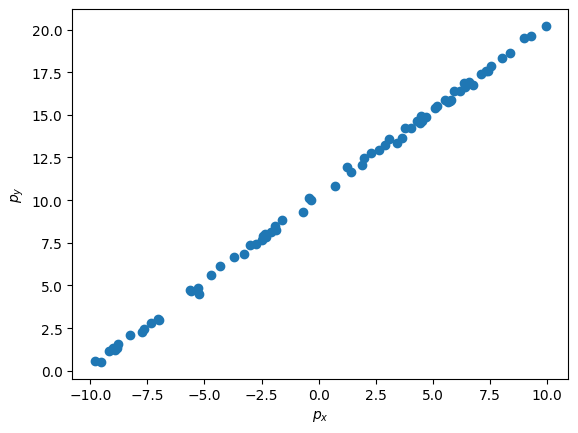

In [18]:
import matplotlib.pyplot as plt 
import numpy as np

# collect a sub-sample of your data
data = np.array(data_rdd.sample(False,0.2).collect())

plt.scatter(data[:,0], data[:,1]);
plt.xlabel(r'$p_x$');
plt.ylabel(r'$p_y$');

**We will now implement a distributed gradient descent and use it to find the best parameters for a linear model.**

Given an input $X$ the ouput of the model is 

$$
Y = W X = w_{0} + w_1 x_1 + \dots + w_p x_p
$$

In our case, we have $Y=y(w,x)$, $W = [w_0, w_1]$ and $X=[1, x]^T$, in other words

$$
y(w,x) = w_0 + w_1 x
$$

We are interested in estimating the optimal parameters $w^\star$ of the line fitting our data. 

To do this we will use **gradient descent**, an iterative procedure that allows us to find a local minumum of a differentiable function.

In our case, we would like to minimize the square residuals, i.e.

$$
J(W,X) = \frac{1}{2n} \sum_{i=1}^{n} [Y(W, X)- y_i]^2 = \frac{1}{2n} \sum_{i=1}^{n} [ (w_0 +w_1x) - y_i]^2
$$

where $y_i$ is the true value. 

In each step of the gradient descent we use the following update rule

$$
W_{i+1} = W_i - \gamma \nabla J_W(W_i, X)
$$

where $\gamma$ is the learning rate, a variable used to reduce the size of each step.


In other word we are moving in the opposite direction of the gradient, i.e. towards the minimum of the function. 

Recalling that $W=[w_0, w_1]$ and $X=[1,x]$ we have that each component of the gradient, i.e. $\frac{\partial}{\partial w_p} J(W,X) $

$$
\nabla J(W, X) = \left[\frac{1}{n} \sum_{i=1}^{n} [Y(W,X)- y_i]\cdot1, \frac{1}{n} \sum_{i=1}^{n} [Y(W,X)- y_i]\cdot x_i \right]
$$

**We can now write a map-reduce job used to estimate the parameters using gradient descent on the full dataset.**

We start by defining the weights vector and initializing it to some values, e.g. $(10, 0.5)$ is a good guess...

In [14]:
# use numpy to create the W weight array
W = np.array([10,0.5])
x=np.array([1,1])

Implement then the functions computing the prediction given as input $x$ and the current weights W

In [15]:
# predict y for any given x and weights W
def predict(x, W):
    # return prediction
    return W[0] + W[1]*x
    # ---
    

# test the function in local 
assert predict(1, [10,1]) == 11
# ---

Implement the function computing the gradient for one example, given as inputs:
1. the point $P=(x,y)$, and 
2. the current set of weights $W$. 

Remember that the gradient has two components, one per parameter. 

Furthermore, the normalization $\frac{1}{n}$ can be ommited since we can apply it afterwards, having summed the gradients of all examples.

In [16]:
# compute the gradient 
def gradient(P, W):
    # return the prediction given the x value of P and the weights W    
    # and compute gradient
    pred = predict(P[0], W)
    gradient = np.dot(pred-P[1], [1,P[0]])
    # ---
    
    return gradient

# test the function in local
assert not (gradient((1,11), [10,1])).all() 
# ---

We are now ready to implement the gradient descent and find the optimal line parameters. 

**Hint**: compute the gradient for each point in parallel, and them sum all of them. Finally, use this sum to update the weights vector. 

In [26]:
# count points based on the partitioned data
num_points = data_rdd.count()

# re-declare the weight vector here: 
#   this is useful if the cell is run multiple times
W = np.array([10,0.5])

# define the learning rate
lr = 0.01

# define the number of iterations
num_it = 20

for i in range(num_it):
    # run the gradient descent in parallel and then sum the gradients 
    grad = data_rdd.flatMap(lambda point: gradient(point,W))\
           .reduce(lambda x, y: x+y)
    # ---
    grad.collect()[:10]
    # update the weights according to the learning rate and the gradient
    #W = W-grad*lr
    # ---    
    
# print the results
print("Final parameters: x0={:.2f}, x1={:.2f}".format(W[0], W[1]))

ERROR:root:KeyboardInterrupt while sending command.                 (1 + 1) / 2]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.9/site-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


23/05/24 09:13:53 WARN AbstractConnector: 
java.io.IOException: Thread signal failed
	at java.base/sun.nio.ch.NativeThread.signal(Native Method)
	at java.base/sun.nio.ch.ServerSocketChannelImpl.implCloseSelectableChannel(ServerSocketChannelImpl.java:365)
	at java.base/java.nio.channels.spi.AbstractSelectableChannel.implCloseChannel(AbstractSelectableChannel.java:242)
	at java.base/java.nio.channels.spi.AbstractInterruptibleChannel.close(AbstractInterruptibleChannel.java:112)
	at org.sparkproject.jetty.server.ServerConnector.close(ServerConnector.java:371)
	at org.sparkproject.jetty.server.AbstractNetworkConnector.shutdown(AbstractNetworkConnector.java:104)
	at org.sparkproject.jetty.server.Server.doStop(Server.java:444)
	at org.sparkproject.jetty.util.component.AbstractLifeCycle.stop(AbstractLifeCycle.java:94)
	at org.apache.spark.ui.ServerInfo.stop(JettyUtils.scala:525)
	at org.apache.spark.ui.WebUI.$anonfun$stop$2(WebUI.scala:180)
	at org.apache.spark.ui.WebUI.$anonfun$stop$2$adapted

KeyboardInterrupt: 

Check out the results by plotting the data points and the resulting best fit line.

In [ ]:
data = np.array(data_rdd.collect())

plt.scatter(data[:,0], data[:,1]);
x = np.arange(-10,11)
y = W[0] + W[1]*x
plt.plot(x, y, color='red', lw=2);
plt.xlabel(r'$x_{0}$');
plt.ylabel(r'$x_{1}$');

Finish up by computing the residuals using Spark, and plot their distribution in a histogram. 

The residual of the point $(x_i, y_i)$ with respect to the model $y(x)$ is simply defined as

$$
R_i = y(x_i) - y_i
$$

In [ ]:
# compute the residuals
residuals_rdd = """ residual evaluation """

In [ ]:
# plot its distribution
plt.hist(residuals_rdd.collect(), range=(-1,1), bins=50);
plt.xlabel("residuals");
plt.ylabel("counts");

**Note**

_By running the previous cell we asked Spark to return the entire `residual` RDD object. 
This is not a sizeable dataset in this specific example, but it might be the case in a real-life scenario, where you may have lots of records stored in a distributed cluster.
Returning the entire dataset just to produce a histogram is extremely inconvenient, as it implies large data transfers from the executors to the driver, and finally to the client (possibly resulting in getting out of the driver memory)._

_What you should be doing instead is to evaluate the histogram remotely and in parallel, and return the histogram as a set of bins and counts.
This way the data transfer from the executors to the driver is minimized, avoiding possible issues._

_You should be able to write a Map-Reduce function to create an histogram (consider this an **Extra-exercise**), but Spark is also providing some built-in functions to compute simple histograms remotely._

In [ ]:
# use the spark RDD histogram method to return the histogram from the cluster
hist = residuals_rdd.histogram(np.linspace(-1,1,50).tolist())
plt.stairs(hist[1], hist[0]);
plt.xlabel("residuals");
plt.ylabel("counts");

## Caching

From the WebUI we can see that in each iteration Spark is computing every operation from the very beginning, i.e. **starting from reading the list of filenames and runnign the parallelization of the text files!**. 
This would not really necessary, as this first operation should not need to be re-executed every time we need to access the dataset.

With `persist()` we can instruct spark to put intermediate results into the executors' memory, e.g. after the function parsing the files. 

In this way the same dataset will be loaded in the next iterations much faster, at the cost of having the dataset stored in memory. 

**Note-1:** to be precise, there could be different levels of [persistence](https://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-persistence) of data into the executors' memory.

**Note-2:** one should be very careful not to _abuse_ the caching of datasets. Caching itself takes time and resources, and caching all intermediate stages of your dataset might end up taking a toll on the performance (and saturating the available memory of the executors).

In [ ]:
# persist the original RDD
data_rdd = data_rdd.persist() 

# persist is a transformation, it will be triggered 
# only once we apply an action on the RDD!

In [ ]:
# run the same code as previously 
# and have a look at the spark application webUI 
# under the Storage tab

print("Final parameters: x0={:.2f}, x1={:.2f}".format(W[0], W[1]))

The RDD can be removed from memory with `unpersist()`, freeing up the executors' memory when needed.

In [ ]:
# free up the memory
data_rdd = data_rdd.unpersist()

# Stop worker and master

In [4]:
# stop the running Spark context
sc.stop()

23/06/16 15:07:33 WARN AbstractConnector: 
java.io.IOException: No such file or directory
	at java.base/sun.nio.ch.NativeThread.signal(Native Method)
	at java.base/sun.nio.ch.ServerSocketChannelImpl.implCloseSelectableChannel(ServerSocketChannelImpl.java:365)
	at java.base/java.nio.channels.spi.AbstractSelectableChannel.implCloseChannel(AbstractSelectableChannel.java:242)
	at java.base/java.nio.channels.spi.AbstractInterruptibleChannel.close(AbstractInterruptibleChannel.java:112)
	at org.sparkproject.jetty.server.ServerConnector.close(ServerConnector.java:371)
	at org.sparkproject.jetty.server.AbstractNetworkConnector.shutdown(AbstractNetworkConnector.java:104)
	at org.sparkproject.jetty.server.Server.doStop(Server.java:444)
	at org.sparkproject.jetty.util.component.AbstractLifeCycle.stop(AbstractLifeCycle.java:94)
	at org.apache.spark.ui.ServerInfo.stop(JettyUtils.scala:525)
	at org.apache.spark.ui.WebUI.$anonfun$stop$2(WebUI.scala:180)
	at org.apache.spark.ui.WebUI.$anonfun$stop$2$ad

In [5]:
# stop the running Spark session
spark.stop()

Finally, use `docker compose down` to stop and clear all running containers.